# 🎭 A Bayesian Journey: Decoding Developer Platforms Through Emojis

### Introduction

Ever wondered how Bayesian analysis can be applied to simple real-world problems? Let's walk through an example where we use Bayesian techniques to predict which developer platform a user might be on based on their emoji usage patterns.


### Setting Up the Environment
First, let's import the necessary libraries and set up our visual style. We'll be using popular Python libraries such as numpy, pandas, matplotlib, and seaborn for data manipulation and visualization. Additionally, we'll use matplotlib.animation to create a GIF that visualizes our Bayesian updating process.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
import warnings
import os
from matplotlib import animation
from IPython.display import HTML

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set the visual style for plots
plt.style.use('default')  # Use default style as base
sns.set_theme(style="whitegrid")  # Apply Seaborn styling
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 10


### Defining Our Synthetic Data
To demonstrate the Bayesian approach, we'll create a synthetic dataset that simulates emoji usage across different developer platforms. This dataset is purely fictional and serves as a sample application to showcase how Bayesian inference may work in practice.

#### Platforms and Emojis
We'll define a list of developer platforms and an expanded set of emojis to represent various expressions.

In [35]:
# List of developer platforms
PLATFORMS = [
    'GitHub', 'Stack Overflow', 'Reddit Dev', 'Discord Dev', 
    'Google Cloud', 'AWS', 'Microsoft Azure', 'Apple Dev',
    'Twitter API', 'GitLab'
]

# Emoji definitions for data generation
EMOJIS = ['😄', '😕', '💻', '🔥', '👍', '😢', '🚀', '😡', '🐛', '❤️']
EMOJI_LABELS = ['Happy', 'Confused', 'Computer', 'Fire', 'Thumbs Up', 'Sad', 'Rocket', 'Angry', 'Bug', 'Heart']
EMOJI_TO_LABEL = dict(zip(EMOJIS, EMOJI_LABELS))
LABEL_TO_EMOJI = {v: k for k, v in EMOJI_TO_LABEL.items()}

#### Generating the Synthetic Dataset
We'll simulate emoji usage patterns for each platform based on fictional characteristics. The data generation process assigns different probabilities to emojis depending on the platform, creating a unique "emoji signature" for each.

In [29]:
def generate_synthetic_data():
    """
    Generates a synthetic dataset representing emoji usage across different platforms.
    """
    np.random.seed(42)  # For reproducibility
    data = []
    
    # Define base probabilities for each emoji on each platform
    platform_probabilities = {
        'GitHub': {'Happy': 0.15, 'Confused': 0.05, 'Computer': 0.20, 'Fire': 0.10, 'Thumbs Up': 0.15,
                   'Sad': 0.05, 'Rocket': 0.15, 'Angry': 0.02, 'Bug': 0.10, 'Heart': 0.08},
        'Stack Overflow': {'Happy': 0.10, 'Confused': 0.15, 'Computer': 0.15, 'Fire': 0.05, 'Thumbs Up': 0.10,
                           'Sad': 0.15, 'Rocket': 0.05, 'Angry': 0.10, 'Bug': 0.15, 'Heart': 0.05},
        # Add definitions for other platforms or use default
    }

    # Default distribution if a platform is not defined
    default_distribution = {'Happy': 0.10, 'Confused': 0.10, 'Computer': 0.15, 'Fire': 0.10, 'Thumbs Up': 0.10,
                            'Sad': 0.10, 'Rocket': 0.10, 'Angry': 0.05, 'Bug': 0.10, 'Heart': 0.10}

    for platform in PLATFORMS:
        probs = platform_probabilities.get(platform, default_distribution)
        counts = np.random.multinomial(1000, [probs[label] for label in EMOJI_LABELS])
        data.append(counts)
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=EMOJIS, index=PLATFORMS)
    df_labels = df.rename(columns=EMOJI_TO_LABEL)
    return df, df_labels

# Generate the data
data, data_labels = generate_synthetic_data()

# Display the first few rows
data_labels.head()

,Happy,Confused,Computer,Fire,Thumbs Up,Sad,Rocket,Angry,Bug,Heart
GitHub,143,55,202,87,160,40,149,18,112,34
Stack Overflow,109,145,148,53,105,152,43,102,143,0
Reddit Dev,118,106,136,94,85,99,104,46,121,91
Discord Dev,99,96,159,109,97,90,87,59,91,113
Google Cloud,105,108,157,101,77,92,107,49,94,110


#### Visualizing the Emoji Distribution
Let's create visualizations to understand our synthetic dataset better. We'll generate a heatmap to show emoji usage across platforms and a bar chart to display the total emoji counts.

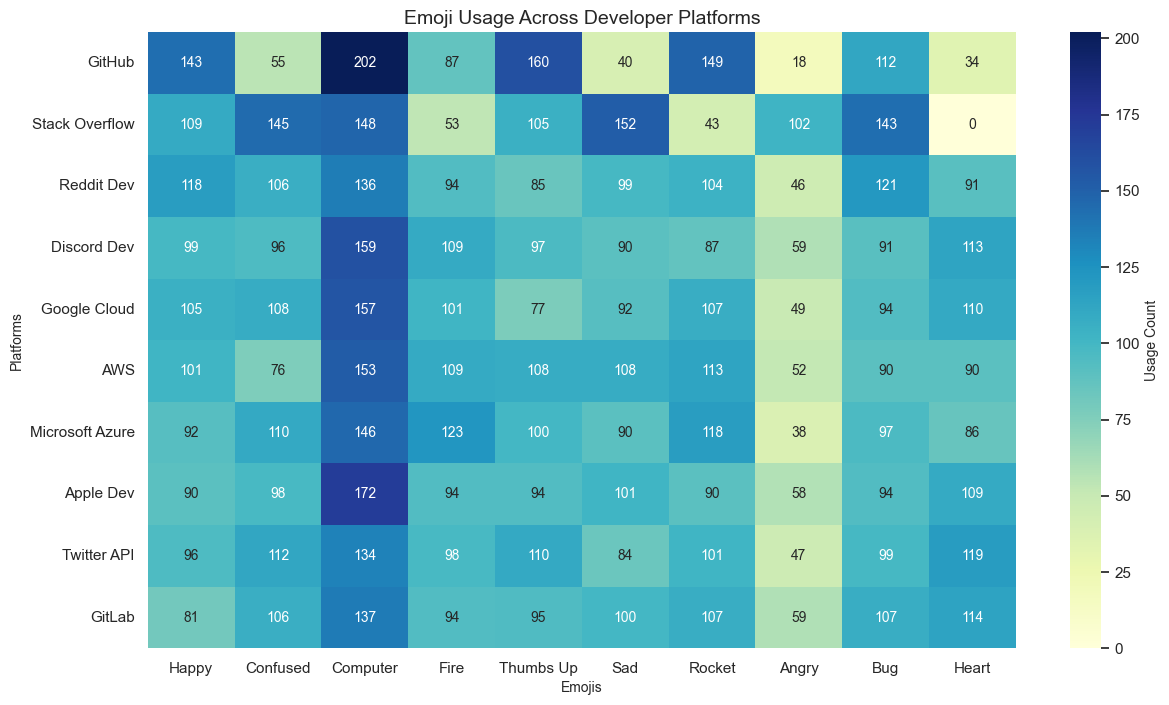

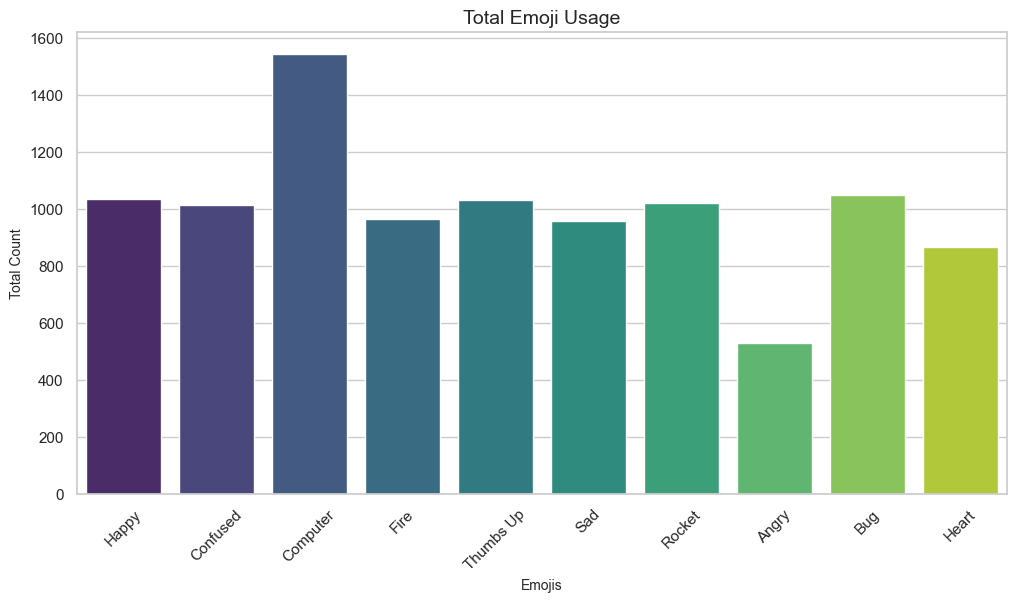

In [30]:
def visualize_data(data_labels):
    """
    Visualizes the emoji usage data using heatmaps and bar charts.
    """
    plt.figure(figsize=(14, 8))
    sns.heatmap(data_labels, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Usage Count'})
    plt.title('Emoji Usage Across Developer Platforms')
    plt.xlabel('Emojis')
    plt.ylabel('Platforms')
    plt.show()
    
    plt.figure(figsize=(12, 6))
    total_emojis = data_labels.sum()
    sns.barplot(x=total_emojis.index, y=total_emojis.values, palette='viridis')
    plt.title('Total Emoji Usage')
    plt.xlabel('Emojis')
    plt.ylabel('Total Count')
    plt.xticks(rotation=45)
    plt.show()

# Visualize the data
visualize_data(data_labels)


### Applying Bayesian Analysis
Now, let's dive into the core of our analysis—applying Bayesian inference to predict the platform based on observed emojis.

### Defining the Naive Bayes Classifier
We'll use a simple Naive Bayes classifier, which assumes that the features (emojis) are independent given the class (platform).

In [31]:
def naive_bayes_train(X, classes, features):
    """
    Trains a Naive Bayes classifier.
    """
    X = X + 1  # Laplace smoothing
    P_feature_given_class = X / X.sum(axis=1, keepdims=True)
    P_class = X.sum(axis=1) / X.sum()
    Model = namedtuple('Model', 'P_feature_given_class P_class classes features')
    return Model(P_feature_given_class, P_class, classes, features)

def naive_bayes_predict(model, x_new):
    """
    Predicts the class probabilities for new data.
    """
    log_prob = np.log(model.P_class)
    for i in range(len(x_new)):
        if x_new[i] > 0:
            log_prob += x_new[i] * np.log(model.P_feature_given_class[:, i])
    prob = np.exp(log_prob - log_prob.max())  # For numerical stability
    prob /= prob.sum()
    return prob


#### Training the Model

In [32]:
# Prepare data for training
X = data.values
classes = data.index.values
features = data.columns.values

# Train the model
model = naive_bayes_train(X, classes, features)


#### Visualizing Bayesian Updates with an Animated GIF
To illustrate how our beliefs update with each observed emoji, we'll create an animated GIF.

### Creating the Animation


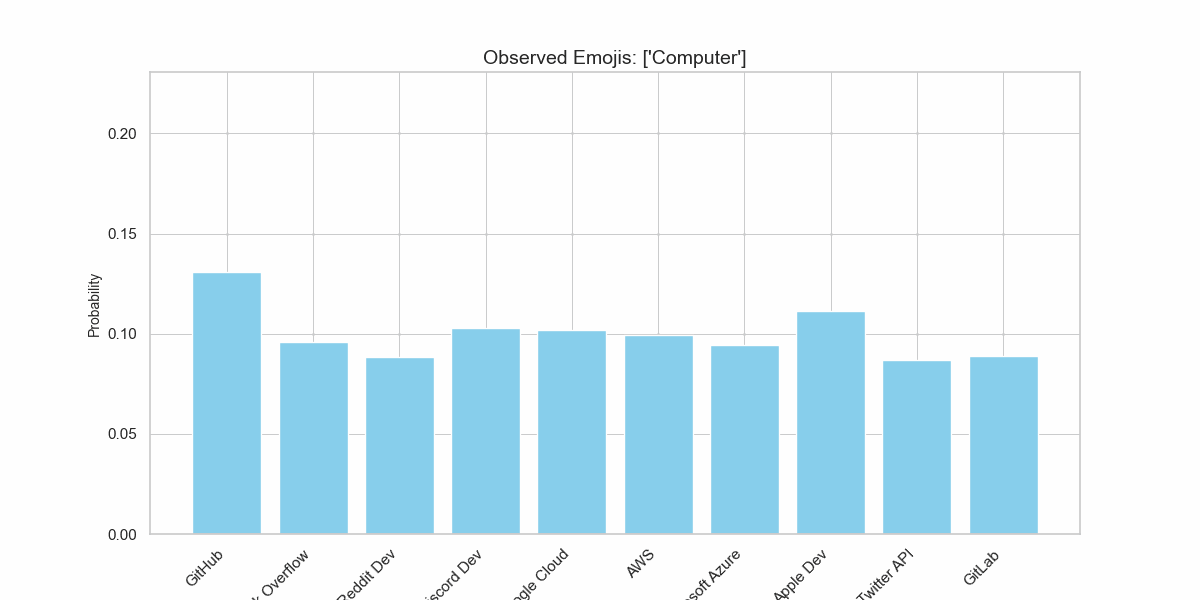

In [36]:
import base64
from IPython.display import HTML, display

def create_bayesian_animation(model, observed_emojis):
    """
    Creates an animated GIF showing Bayesian updates.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(model.classes, model.P_class, color='skyblue')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Probability')
    ax.set_title('Bayesian Updates')
    ax.set_xticklabels(model.classes, rotation=45, ha='right')

    def animate(i):
        x_new = np.zeros(len(model.features))
        for emoji in observed_emojis[:i+1]:
            idx = list(model.features).index(emoji)
            x_new[idx] += 1
        probabilities = naive_bayes_predict(model, x_new)
        for bar, new_height in zip(bars, probabilities):
            bar.set_height(new_height)
        pattern_labels = [EMOJI_TO_LABEL[emoji] for emoji in observed_emojis[:i+1]]
        ax.set_title(f'Observed Emojis: {pattern_labels}')
        ax.set_ylim(0, probabilities.max() + 0.1)

    anim = animation.FuncAnimation(fig, animate, frames=len(observed_emojis), interval=1500)

    # Save the animation locally
    anim.save('bayesian_update.gif', writer='pillow')
    plt.close(fig)

    # Encode the GIF to base64 to embed in the notebook
    with open('bayesian_update.gif', 'rb') as f:
        gif_data = f.read()
    b64_data = base64.b64encode(gif_data).decode('utf-8')

    # Embed the GIF in the notebook
    return HTML(f'<img src="data:image/gif;base64,{b64_data}">')

# Observed sequence of emojis
observed_emojis = ['💻', '🐛', '😕', '😡']

# Create and display the animation
display(create_bayesian_animation(model, observed_emojis))


### Interpreting the Results
Initial Beliefs: We start with prior probabilities based on the overall emoji usage across platforms.

Updating Beliefs: With each observed emoji, we update our beliefs about which platform the user might be on.

Final Prediction: After observing all emojis, the platform with the highest probability is our prediction.

This demonstrates how Bayesian inference allows us to update our predictions in light of new evidence, which is a powerful tool in many real-world applications.

In our case we start with giving highest probability to GitHub when '💻' is the only emoji but as more emojies appear Stack Overflow takes the lead.



#### Conclusion
Through this example, we've seen how Bayesian analysis can be applied to make predictions based on observed data, even with synthetic datasets. This approach is widely used in various fields, including natural language processing, spam detection, and recommendation systems.